# Parkinsons Disease detection Using Machine Learning Algorithms

In [2]:
# Built-in packages
import json
import warnings
import re
warnings.filterwarnings("ignore")

# Third party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import iplot

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier


sns.set(context= "notebook", color_codes=True)
plt.style.use('bmh')

pyo.init_notebook_mode()

%matplotlib inline
pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'pandas'

**name**$~~~~~~~~~~~~~~~~~~~~~~~~~$- ASCII subject name and recording number
____
**MDVP:Fo(Hz)**$~~~~~~~~~~~~~$- Average vocal fundamental frequency
____
**MDVP:Fhi(Hz)**$~~~~~~~~~~~~$- Maximum vocal fundamental frequency
____
**MDVP:Flo(Hz)**$~~~~~~~~~~~~$- Minimum vocal fundamental frequency
____
**MDVP:Jitter(%), <br>
MDVP:Jitter(Abs), <br>
MDVP:RAP, <br>
MDVP:PPQ, <br>
Jitter:DDP**$~~~~~~~~~~~~~~~~~~$- Several measures of variation in fundamental frequency
____
**MDVP:Shimmer, <br>
MDVP:Shimmer(dB), <br>
Shimmer:APQ3, <br>
Shimmer:APQ5, <br>
MDVP:APQ, <br>
Shimmer:DDA**$~~~~~~~~~~~~~$- Several measures of variation in amplitude
____
**NHR,HNR**$~~~~~~~~~~~~~~~~~~~$- Two measures of ratio of noise to tonal components in the voice
____
**status**$~~~~~~~~~~~~~~~~~~~~~~~~$- Health status of the subject (one) - Parkinson's, (zero) - healthy
____
**RPDE,D2**$~~~~~~~~~~~~~~~~~~~~$- Two nonlinear dynamical complexity measures
____
**DFA**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Signal fractal scaling exponent
____
**spread1, <br>
spread2, <br>
PPE**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Three nonlinear measures of fundamental frequency variation
____

In [84]:
# Read the CSV file and store it in a DataFrame
df = pd.read_csv("parkinsons.data")

# Replace spaces, parentheses, colons, and percentage signs in column names with underscores
# Convert column names to lowercase
# This is done for consistency and to ensure compatibility with Python syntax
df.columns = [
    i.replace(" ", "_")  # Replace spaces with underscores
    .replace("(%)", "_perc")  # Replace percentage signs with _perc
    .replace("(dB)", "_db")  # Replace dB with _db
    .replace(":", "_")  # Replace colons with underscores
    .lower()  # Convert column names to lowercase
    for i in df.columns  # Iterate over each column name
]

# Remove parentheses and their content from column names using regular expressions
# This is done to make column names more concise and readable
df.columns = [re.sub(r"\((.+)\)", "", i) for i in df.columns]
df

,name,mdvp_fo,mdvp_fhi,mdvp_flo,mdvp_jitter_perc,mdvp_jitter,mdvp_rap,mdvp_ppq,jitter_ddp,mdvp_shimmer,mdvp_shimmer_db,shimmer_apq3,shimmer_apq5,mdvp_apq,shimmer_dda,nhr,hnr,status,rpde,dfa,spread1,spread2,d2,ppe
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,0.01604,0.01657,0.01879,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,0.01268,0.01365,0.01667,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,0.01265,0.01321,0.01588,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [78]:
print(f"The shape of the DatFrame is: {df.shape}, which means there are {df.shape[0]} rows and {df.shape[1]} columns.")

The shape of the DatFrame is: (195, 24), which means there are 195 rows and 24 columns.


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   mdvp_fo           195 non-null    float64
 2   mdvp_fhi          195 non-null    float64
 3   mdvp_flo          195 non-null    float64
 4   mdvp_jitter_perc  195 non-null    float64
 5   mdvp_jitter       195 non-null    float64
 6   mdvp_rap          195 non-null    float64
 7   mdvp_ppq          195 non-null    float64
 8   jitter_ddp        195 non-null    float64
 9   mdvp_shimmer      195 non-null    float64
 10  mdvp_shimmer_db   195 non-null    float64
 11  shimmer_apq3      195 non-null    float64
 12  shimmer_apq5      195 non-null    float64
 13  mdvp_apq          195 non-null    float64
 14  shimmer_dda       195 non-null    float64
 15  nhr               195 non-null    float64
 16  hnr               195 non-null    float64
 1

In [80]:
# Checking if any of the columns have null values
print(df.isnull().sum())

name                0
mdvp_fo             0
mdvp_fhi            0
mdvp_flo            0
mdvp_jitter_perc    0
mdvp_jitter         0
mdvp_rap            0
mdvp_ppq            0
jitter_ddp          0
mdvp_shimmer        0
mdvp_shimmer_db     0
shimmer_apq3        0
shimmer_apq5        0
mdvp_apq            0
shimmer_dda         0
nhr                 0
hnr                 0
status              0
rpde                0
dfa                 0
spread1             0
spread2             0
d2                  0
ppe                 0
dtype: int64


In [86]:
# Generating summary statistics for numerical columns in the DataFrame
df_summary = df.describe()

# Displaying the summary statistics DataFrame
# This provides an overview of the central tendency, dispersion, and shape of the numerical data
df_summary


,mdvp_fo,mdvp_fhi,mdvp_flo,mdvp_jitter_perc,mdvp_jitter,mdvp_rap,mdvp_ppq,jitter_ddp,mdvp_shimmer,mdvp_shimmer_db,shimmer_apq3,shimmer_apq5,mdvp_apq,shimmer_dda,nhr,hnr,status,rpde,dfa,spread1,spread2,d2,ppe
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [87]:
df["status"].value_counts()

1    147
0     48
Name: status, dtype: int64

<Axes: xlabel='status', ylabel='count'>

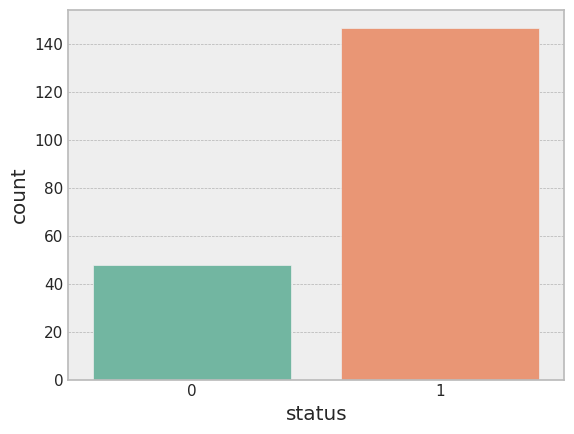

In [89]:
# Genrating a count plot to visualize the distribution of the "status" column in the DataFrame
# The x-axis represents the values of the "status" column
# The data parameter specifies the DataFrame from which the data is retrieved
sns.countplot(x="status", data=df, palette="Set2")


In [94]:
df.groupby("status").mean()

,mdvp_fo,mdvp_fhi,mdvp_flo,mdvp_jitter_perc,mdvp_jitter,mdvp_rap,mdvp_ppq,jitter_ddp,mdvp_shimmer,mdvp_shimmer_db,shimmer_apq3,shimmer_apq5,mdvp_apq,shimmer_dda,nhr,hnr,rpde,dfa,spread1,spread2,d2,ppe
status,,,,,,,,,,,,,,,,,,,,,,
0,181.937771,223.636750,145.207292,0.003866,0.000023,0.001925,0.002056,0.005776,0.017615,0.162958,0.009504,0.010509,0.013305,0.028511,0.011483,24.678750,0.442552,0.695716,-6.759264,0.160292,2.154491,0.123017
1,145.180762,188.441463,106.893558,0.006989,0.000051,0.003757,0.003900,0.011273,0.033658,0.321204,0.017676,0.020285,0.027600,0.053027,0.029211,20.974048,0.516816,0.725408,-5.333420,0.248133,2.456058,0.233828


In [110]:
# Checking for missing values (NaN) in the DataFrame
# The isna() method returns a DataFrame of the same shape as df, where each element is True if the corresponding element in df is NaN, and False otherwise
# The sum() method is then applied to count the number of missing values in each column
df.isna().sum()

name                0
mdvp_fo             0
mdvp_fhi            0
mdvp_flo            0
mdvp_jitter_perc    0
mdvp_jitter         0
mdvp_rap            0
mdvp_ppq            0
jitter_ddp          0
mdvp_shimmer        0
mdvp_shimmer_db     0
shimmer_apq3        0
shimmer_apq5        0
mdvp_apq            0
shimmer_dda         0
nhr                 0
hnr                 0
status              0
rpde                0
dfa                 0
spread1             0
spread2             0
d2                  0
ppe                 0
dtype: int64

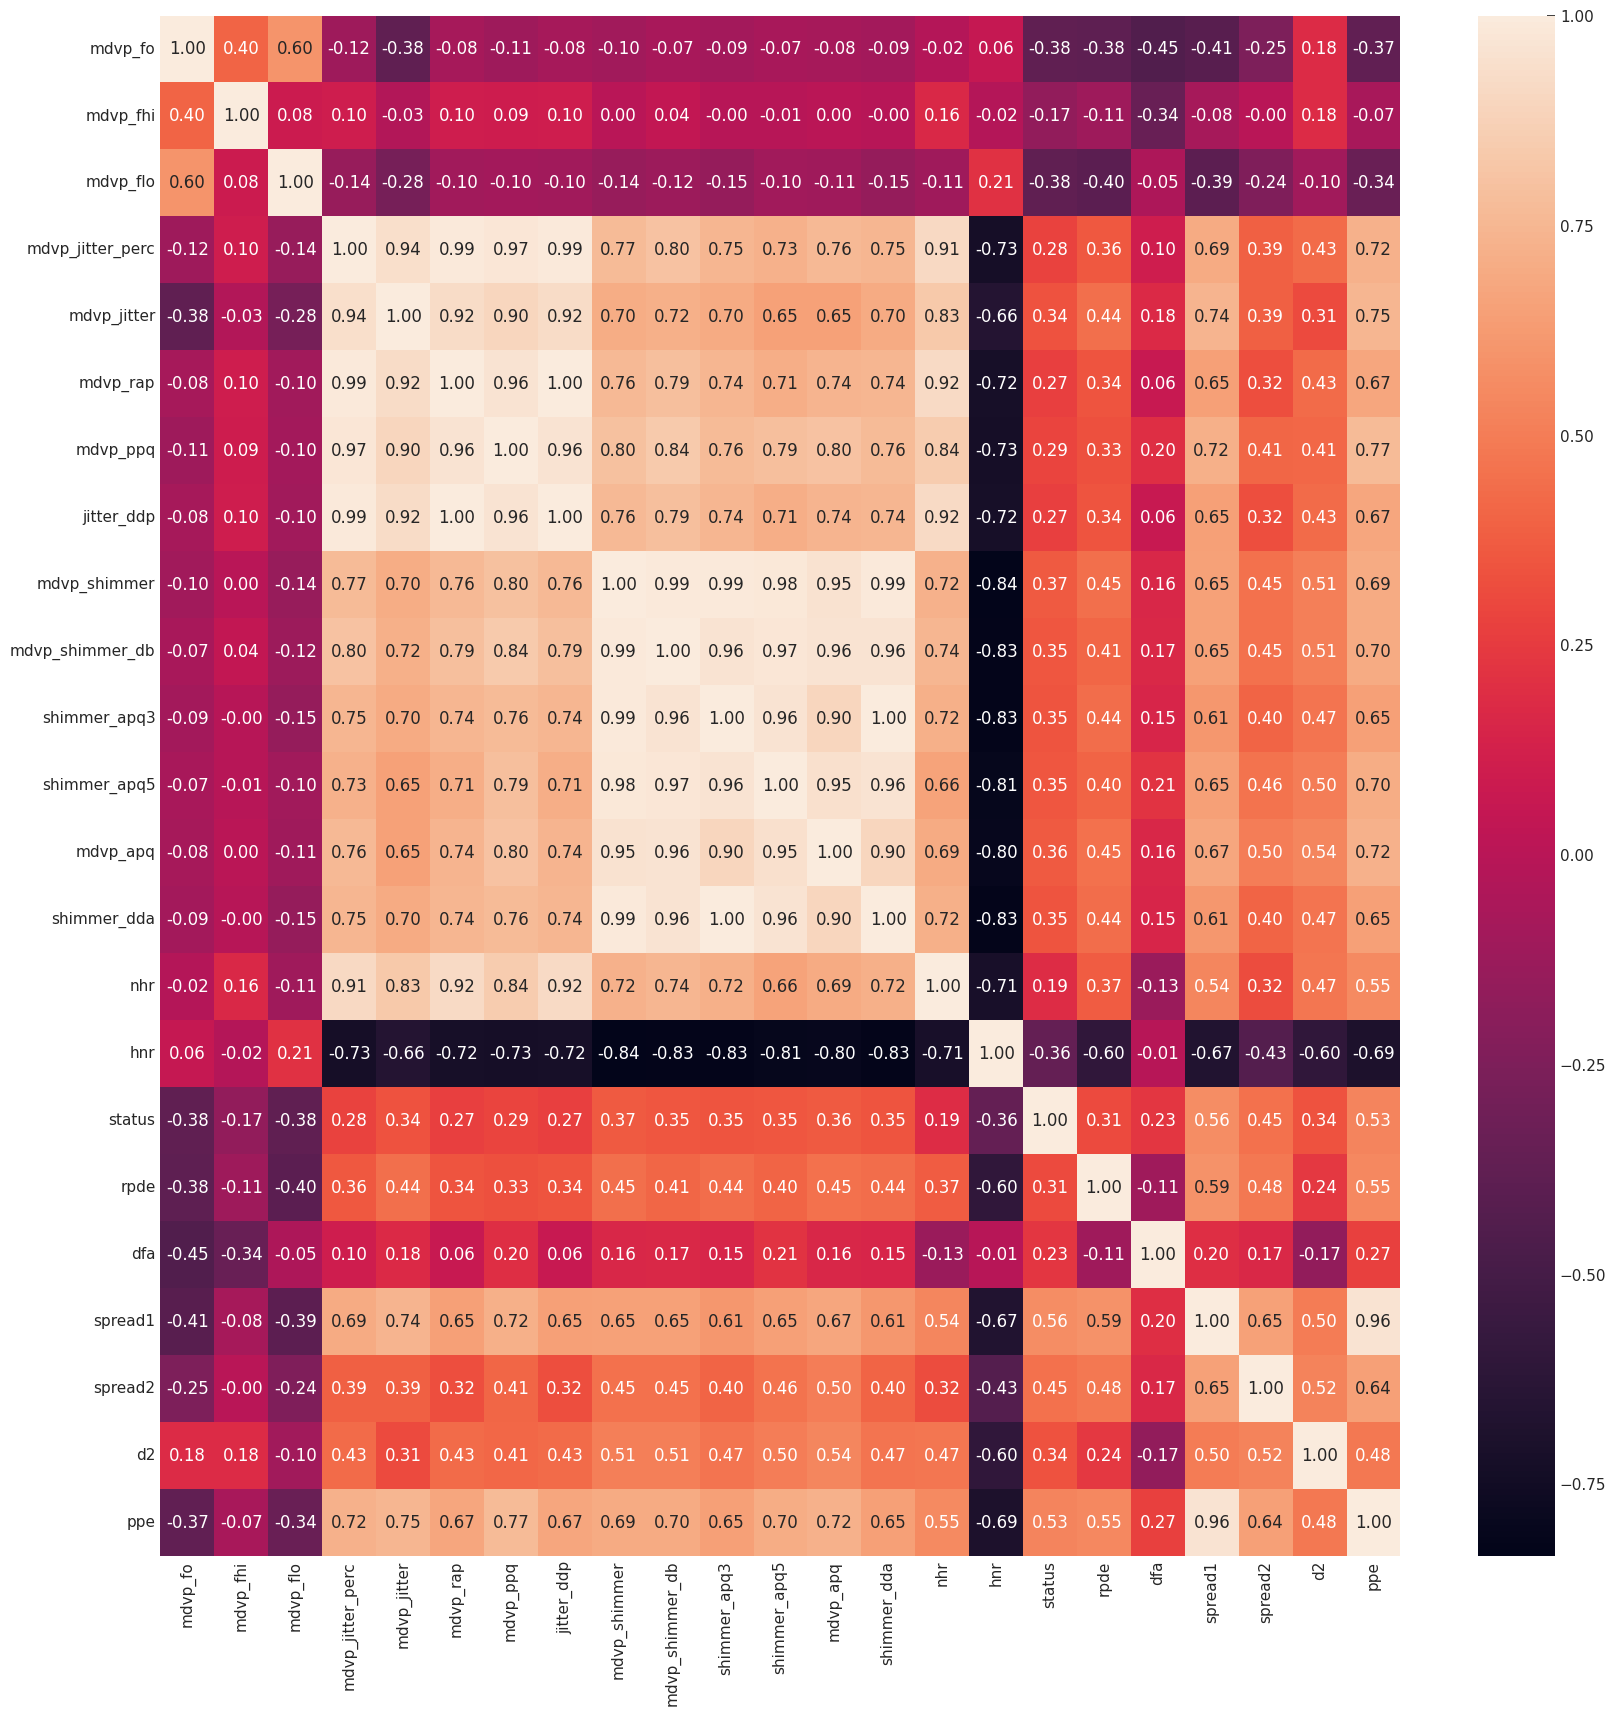

In [111]:
# Create a figure with a specified size (20x20 inches) for the heatmap plot
plt.figure(figsize=(20, 20))

# Generate a heatmap to visualize the correlation matrix of the DataFrame
# The corr() method computes the pairwise correlation of columns, excluding NaN values
# The heatmap() function from Seaborn is used to create a heatmap plot
sns.heatmap(df.corr(), fmt='.2f', annot=True);


In [97]:
# Removing the columns "name" and "status" from the DataFrame and store the result in variable x
# The drop() function is used to remove columns along the specified axis (axis=1 for columns)
# The columns to be removed are specified in the list ["name", "status"]
x = df.drop(columns=["name", "status"], axis=1)

# Storing the "status" column as the target variable y
# This column represents the labels or target values that the model aims to predict
y = df["status"]

# This displays the DataFrame x, which contains all columns except "name" and "status"
print(x)


     mdvp_fo  mdvp_fhi  mdvp_flo  mdvp_jitter_perc  mdvp_jitter  mdvp_rap  \
0    119.992   157.302    74.997           0.00784      0.00007   0.00370   
1    122.400   148.650   113.819           0.00968      0.00008   0.00465   
2    116.682   131.111   111.555           0.01050      0.00009   0.00544   
3    116.676   137.871   111.366           0.00997      0.00009   0.00502   
4    116.014   141.781   110.655           0.01284      0.00011   0.00655   
..       ...       ...       ...               ...          ...       ...   
190  174.188   230.978    94.261           0.00459      0.00003   0.00263   
191  209.516   253.017    89.488           0.00564      0.00003   0.00331   
192  174.688   240.005    74.287           0.01360      0.00008   0.00624   
193  198.764   396.961    74.904           0.00740      0.00004   0.00370   
194  214.289   260.277    77.973           0.00567      0.00003   0.00295   

     mdvp_ppq  jitter_ddp  mdvp_shimmer  mdvp_shimmer_db  shimmer_apq3  \
0

In [98]:
print(y)

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64


In [112]:
# Defining a function that computes value counts for a specified column, segmented by the "status" column
def groupby_get_cc_count(tdf, col):
    # Grouping the DataFrame by the specified column and "status", count occurrences, and reset index
    tdf = tdf.groupby([col, "status"])["status"].count().reset_index(level=0)
    tdf.columns = [col, "count"]
    tdf = tdf.reset_index()
    return tdf


In [113]:
df[["mdvp_fo", "mdvp_jitter", "status"]]

,mdvp_fo,mdvp_jitter,status
0,119.992,0.00007,1
1,122.400,0.00008,1
2,116.682,0.00009,1
3,116.676,0.00009,1
4,116.014,0.00011,1
...,...,...,...
190,174.188,0.00003,0
191,209.516,0.00003,0
192,174.688,0.00008,0
193,198.764,0.00004,0


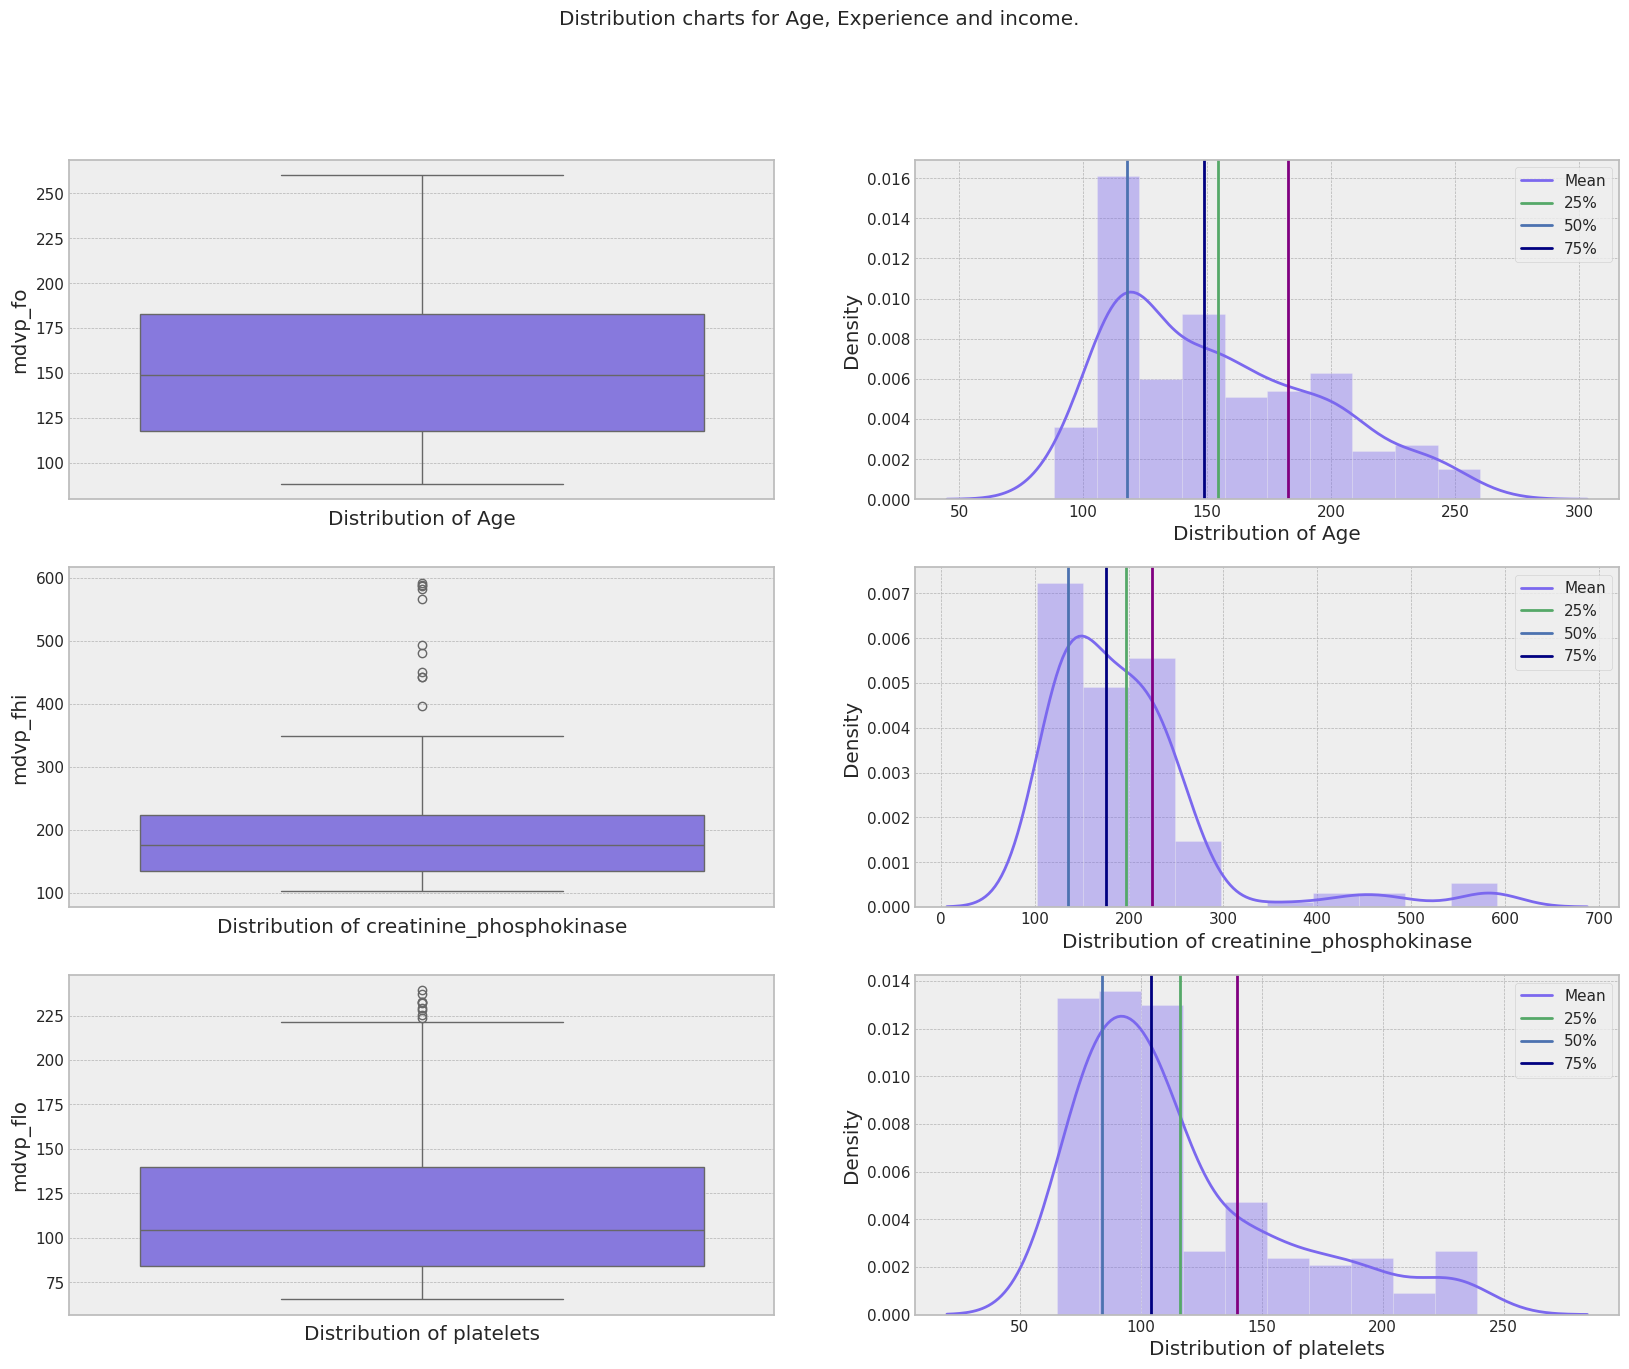

In [12]:
def draw_axvlines(plt, col):
    mean = df_summary.loc["mean", col]
    q1 = df_summary.loc["25%", col]
    q2 = df_summary.loc["50%", col]
    q3 = df_summary.loc["75%", col]
    plt.axvline(mean, color = "g");              # Plotting a line to mark the mean
    plt.axvline(q1, color = "b");                # Plotting a line to mark Q1
    plt.axvline(q2, color = "navy");             # Plotting a line to mark Q2
    plt.axvline(q3, color = "purple");           # Plotting a line to mark Q3
    plt.legend({"Mean": mean, "25%" : q1, "50%" : q2, "75%" : q3});

fig, axes = plt.subplots(3, 2, figsize = (20,15));
fig.suptitle('Distribution charts for Age, Experience and income.');


# Create boxplot to show distribution of Age
sns.boxplot(df["mdvp_fo"], ax = axes[0][0], color = "mediumslateblue");
axes[0][0].set(xlabel = 'Distribution of Age');

pp = sns.distplot(df["mdvp_fo"], ax = axes[0][1], bins = 10, color = "mediumslateblue");
axes[0][1].set(xlabel = 'Distribution of Age');
draw_axvlines(pp, "mdvp_fo");


# Create boxplot to show distribution of creatinine_phosphokinase
sns.boxplot(df["mdvp_fhi"], ax = axes[1][0], color = "mediumslateblue");
axes[1][0].set(xlabel = 'Distribution of creatinine_phosphokinase');

pp = sns.distplot(df["mdvp_fhi"], ax = axes[1][1], bins = 10, color = "mediumslateblue");
axes[1][1].set(xlabel = 'Distribution of creatinine_phosphokinase');
draw_axvlines(pp, "mdvp_fhi")


# Create boxplot to show distribution of platelets
sns.boxplot(df["mdvp_flo"], ax = axes[2][0], color = "mediumslateblue");
axes[2][0].set(xlabel = 'Distribution of platelets');

pp = sns.distplot(df["mdvp_flo"], ax = axes[2][1], color = "mediumslateblue");
axes[2][1].set(xlabel = 'Distribution of platelets');
draw_axvlines(pp, "mdvp_flo")

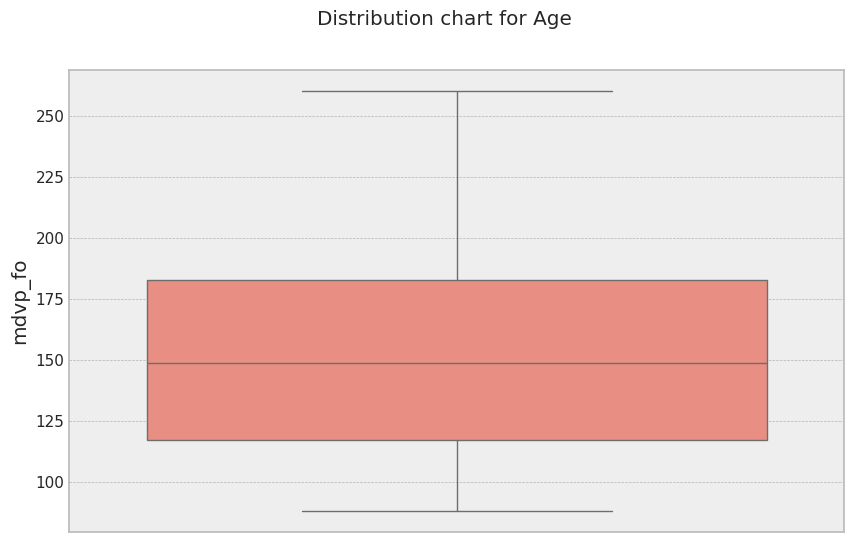

In [135]:
def draw_axvlines(plt, col):
    mean = df_summary.loc["mean", col]
    q1 = df_summary.loc["25%", col]
    q2 = df_summary.loc["50%", col]
    q3 = df_summary.loc["75%", col]
    plt.axvline(mean, color = "g");              # Plotting a line to mark the mean
    plt.axvline(q1, color = "b");                # Plotting a line to mark Q1
    plt.axvline(q2, color = "navy");             # Plotting a line to mark Q2
    plt.axvline(q3, color = "purple");           # Plotting a line to mark Q3
    plt.legend({"Mean": mean, "25%" : q1, "50%" : q2, "75%" : q3});

fig, axes = plt.subplots(1, 1, figsize = (10,6));
fig.suptitle('Distribution chart for Age');


# Create a violin plot to show the distribution of Age
sns.boxplot(data=df["mdvp_fo"], color="salmon")
plt.show()

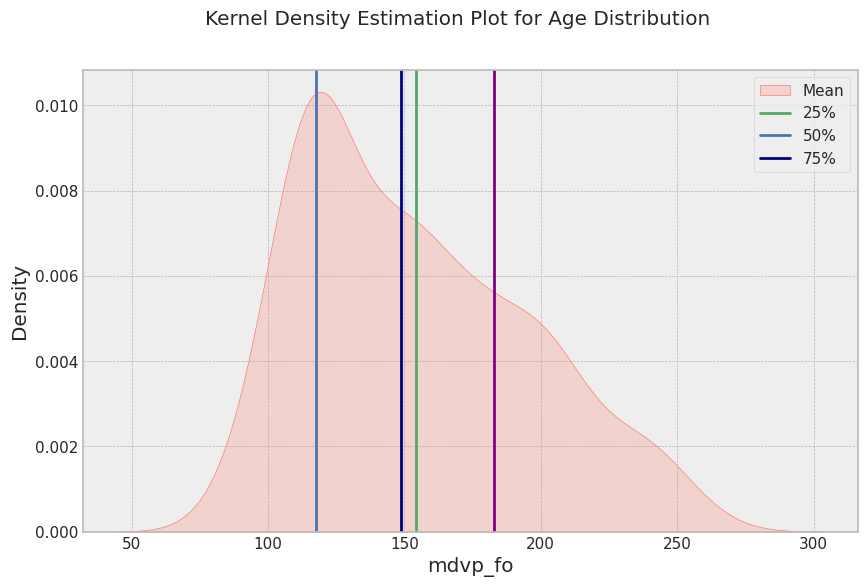

In [136]:
# Create subplots with a single plot, specifying the figure size
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Kernel Density Estimation Plot for Age Distribution')

# The kdeplot() function from Seaborn is used to generate the plot
pp = sns.kdeplot(data=df["mdvp_fo"], color="salmon", fill=True)

# Calling the draw_axvlines function to draw vertical lines indicating statistical measures
draw_axvlines(pp, "mdvp_fo")

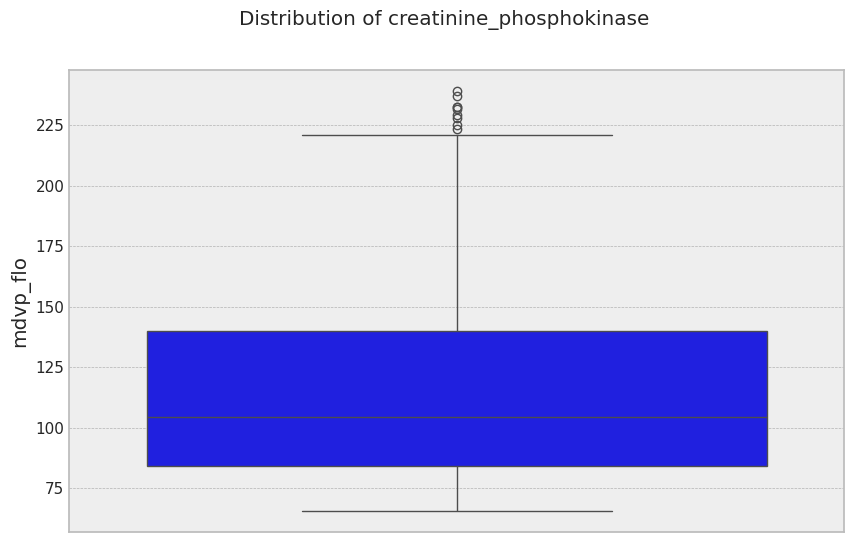

In [139]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Distribution of creatinine_phosphokinase')

# Create boxplot to show distribution of creatinine_phosphokinase
sns.boxplot(df["mdvp_fhi"], color = "blue");


# # Create boxplot to show distribution of platelets
# sns.boxplot(df["mdvp_flo"], ax = axes[2][0], color = "mediumslateblue");
# axes[2][0].set(xlabel = 'Distribution of platelets');

# pp = sns.distplot(df["mdvp_flo"], ax = axes[2][1], color = "mediumslateblue");
# axes[2][1].set(xlabel = 'Distribution of platelets');
# draw_axvlines(pp, "mdvp_flo")

In [144]:
# Creating a copy of the DataFrame "df" and remove the column "name"
df_train = df.copy().drop(columns=["name"])

# Extracting the column names from the modified DataFrame and store them in a list
col_names = df_train.columns.tolist()

# Specifying the target column as "status"
target_col = ["status"]

# Removing the target column from the list of column names
col_names.remove(target_col[0])

# Rearranging the columns in the DataFrame by placing the target column at the end
df_train = df_train[col_names + target_col]


<Axes: >

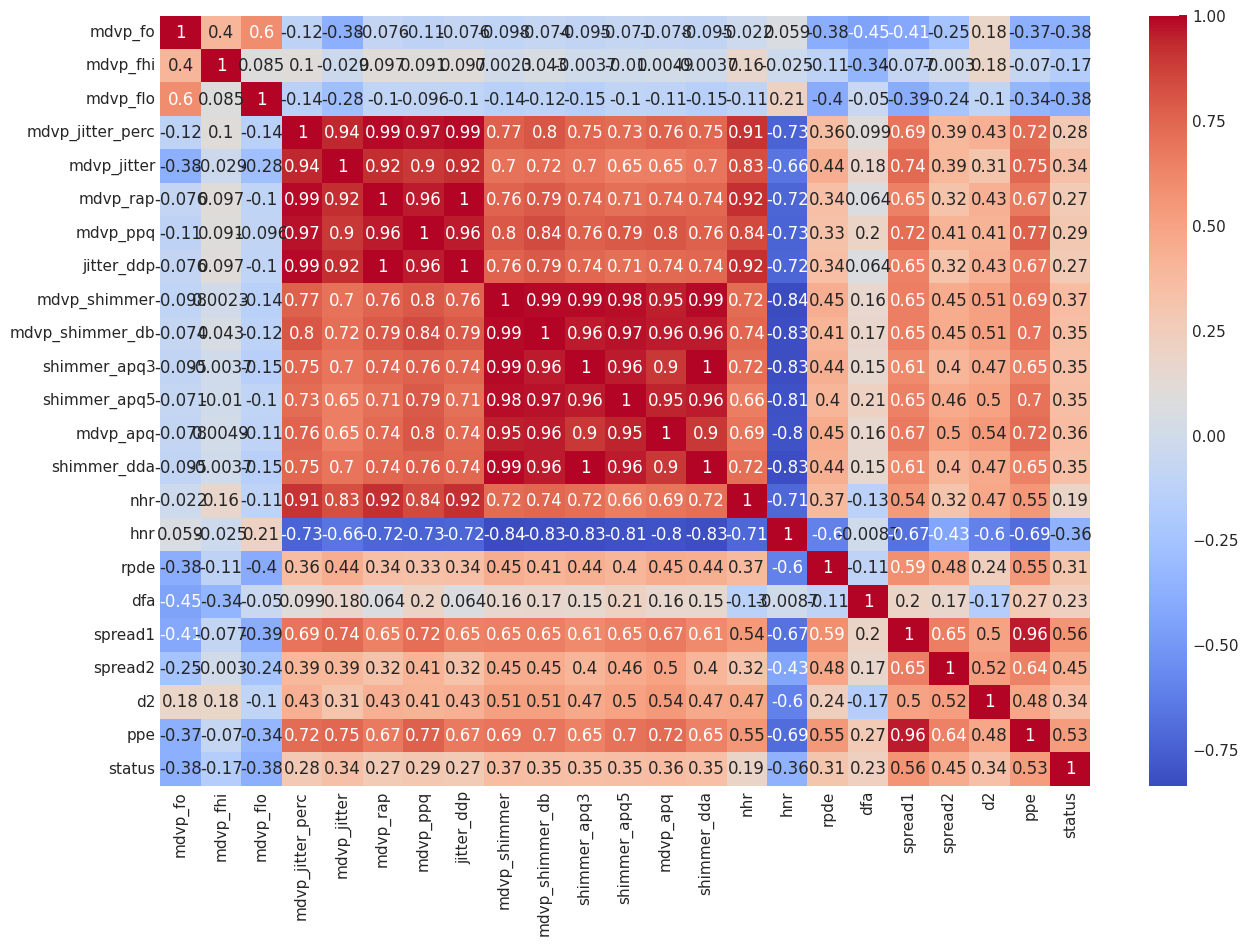

In [147]:
# Set the figure size for the heatmap plot
plt.figure(figsize=(15, 10))

# Compute the correlation matrix for the DataFrame "df_train"
corr = df_train.corr()

# Generate a heatmap to visualize the correlation matrix
# The heatmap() function from Seaborn is used to create the heatmap plot
sns.heatmap(corr, annot=True, fmt='.2g', cmap='coolwarm')


## Standardization: transforms numerical features to have a mean of 0 and a standard deviation of

In [149]:
# Creating a StandardScaler object for standardization
std = StandardScaler()

# The fit_transform() method fits the scaler to the data and transforms it simultaneously
scaled = std.fit_transform(df_train[col_names])

# Converting the scaled array into a DataFrame with column names preserved
scaled = pd.DataFrame(scaled, columns=col_names)

# Concatenating the scaled DataFrame with the target column "status" to create the final training DataFrame
df_train = pd.concat([scaled, df_train[target_col]], axis=1)

# Displaying the first few rows of the modified DataFrame
df_train.head()


,mdvp_fo,mdvp_fhi,mdvp_flo,mdvp_jitter_perc,mdvp_jitter,mdvp_rap,mdvp_ppq,jitter_ddp,mdvp_shimmer,mdvp_shimmer_db,shimmer_apq3,shimmer_apq5,mdvp_apq,shimmer_dda,nhr,hnr,rpde,dfa,spread1,spread2,d2,ppe,status
0,-0.829300,-0.436165,-0.952037,0.334914,0.749759,0.132963,0.760800,0.131755,0.745985,0.739536,0.607859,1.119147,0.332985,0.607532,-0.067893,-0.193225,-0.807838,1.760814,0.801323,0.480477,-0.210531,0.868886,1
1,-0.770972,-0.530974,-0.057721,0.715418,1.037674,0.453892,1.276809,0.452684,1.681731,1.768464,1.547912,2.276504,1.159454,1.548254,-0.137843,-0.634508,-0.387524,1.837562,1.479853,1.311185,0.275077,1.803605,1
2,-0.909476,-0.723168,-0.109875,0.884991,1.325589,0.720770,1.585687,0.721813,1.202693,1.027636,1.175643,1.726176,0.699187,1.175323,-0.291633,-0.279760,-0.662075,1.942048,1.141445,1.017682,-0.103629,1.402661,1
3,-0.909622,-0.649092,-0.114229,0.775389,1.325589,0.578885,1.284076,0.577677,1.340396,1.207698,1.340547,1.848749,0.806859,1.340229,-0.280719,-0.281346,-0.613134,1.832380,1.440945,1.293840,0.062145,1.806954,1
4,-0.925657,-0.606245,-0.130608,1.368893,1.901418,1.095750,2.047187,1.096793,1.836448,1.552389,1.899444,2.532491,1.216839,1.899461,-0.178026,-0.506745,-0.783021,1.909364,1.780940,0.096195,-0.130026,2.267082,1


In [150]:
X = df_train[col_names]      # Contains the independent columns
y = df_train[target_col]     # Our target column

In [151]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 323)
train_y = train_y["status"]
test_y = test_y["status"]

In [174]:
conf_matrix_all = {}

def parkinsons_disease_prediction(name, algo, training_x, testing_x, training_y, testing_y, plot) :
    algo.fit(training_x,training_y)                           # Fit the training data set to the algorithm passed.
    predictions = algo.predict(testing_x)                     # Get all predictions
    probabilities = algo.predict_proba(testing_x)             # Get probablities of predictions

    conf_matrix = confusion_matrix(testing_y, predictions)    # Get confusion matrix using the predictions
    tn, fp, fn, tp = conf_matrix.ravel()

    conf_matrix_all[name] = conf_matrix                       # Save confusion matrix values to a dictionary

    print("Classification report:")                           # Print the classification report
    print(classification_report(testing_y, predictions))

    model_roc_auc = roc_auc_score(testing_y, predictions)           # Get the Area under the curve number
    fpr,tpr,thresholds = roc_curve(testing_y, probabilities[:,1])   # Get False postive rate and true positive rate




### K-nearest Neighbors

In [175]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_neighbors = 2, weights='distance')

parkinsons_disease_prediction("K-Nearest Neighbours", knn, train_X, test_X, train_y, test_y, plot=True)

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.98      0.98      0.98        47

    accuracy                           0.97        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.97      0.97      0.97        59



### Logistic Regression

In [176]:
lr  = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, penalty="l1", solver='liblinear')

parkinsons_disease_prediction("Logistic Regression", lr, train_X, test_X, train_y, test_y, plot = True)

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.96      0.94      0.95        47

    accuracy                           0.92        59
   macro avg       0.86      0.88      0.87        59
weighted avg       0.92      0.92      0.92        59



### Naïve Bayes

In [177]:
gnb = GaussianNB(priors=None, var_smoothing=1e-09)

parkinsons_disease_prediction("Gaussian Naïve Bayes", gnb, train_X, test_X, train_y, test_y, plot=True)

Classification report:
              precision    recall  f1-score   support

           0       0.39      0.92      0.55        12
           1       0.97      0.64      0.77        47

    accuracy                           0.69        59
   macro avg       0.68      0.78      0.66        59
weighted avg       0.85      0.69      0.72        59



### Support Vector Classifier

In [178]:
svc = SVC(C=1.0, kernel='linear', degree= 2, gamma=1.0, random_state=None,
          coef0=0.0, shrinking=True, probability=True,tol=0.001,
          cache_size=200, class_weight=None, verbose=False,max_iter= -1)

parkinsons_disease_prediction("Support Vector Classifier", svc, train_X, test_X, train_y, test_y, plot=True)

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.96      0.91      0.93        47

    accuracy                           0.90        59
   macro avg       0.83      0.87      0.85        59
weighted avg       0.91      0.90      0.90        59



## Ensemble technique employed:
Stacking Classifier (StackingCVClassifier) combining Logistic Regression, K-nearest Neighbors, and Support Vector Classifier predictions, evaluated using cross-validation and compared against individual classifiers.

In [179]:
sclf = StackingCVClassifier(classifiers=[lr, knn, svc],
                            meta_classifier=LogisticRegression(),
                            random_state=42)

for clf, label in zip([lr, knn, svc, sclf], ["Logistic Regression" , 'KNN', 'Support Vector', 'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

print("\n")
parkinsons_disease_prediction("Stacking Classifier", sclf, train_X, test_X, train_y, test_y, plot=True)

Accuracy: 0.85 (+/- 0.05) [Logistic Regression]
Accuracy: 0.81 (+/- 0.06) [KNN]
Accuracy: 0.84 (+/- 0.06) [Support Vector]
Accuracy: 0.81 (+/- 0.06) [StackingClassifier]


Classification report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.98      0.98      0.98        47

    accuracy                           0.97        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.97      0.97      0.97        59



In [181]:
import joblib

# Train the stacking classifier
sclf.fit(train_X, train_y)

# Save the trained model to a file
joblib.dump(sclf, 'ensembled_model.pkl')

print("Ensembled model saved successfully.")


Ensembled model saved successfully.
